In [1]:
import os
import pickle
import numpy as np
import random 
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

import torch
import torch.utils.data as data
from torch.utils.tensorboard import SummaryWriter

import torchvision.transforms as transforms
from torchvision.ops import sigmoid_focal_loss
import segmentation_models_pytorch as smp
from torchvision.ops import masks_to_boxes

from torchgeo.models import ResNet18_Weights,ResNet50_Weights

#our files
import utils
from dataloader import CroppedSegmentationDataset,FullImageDataset
import models

In [5]:
# args = utils.parse_arguments()
#Parameters
data_dir= r"/scratch/kj1447/gracelab/dataset"
model_dir = os.path.join("/scratch/kj1447/gracelab/models","cropped_sentinel_resnet18_augmentation_focal_75")
loss_type = "FOCAL"
# N_EPOCHS = 250
BATCH_SIZE = 8
num_workers = 8
train_ratio = 0.8
# learning_rate = 1e-3
# lookback = 15
seed = 42
# starting_epoch = 99
resume = True
in_channels = 13
use_timepoints = False

In [6]:
if not os.path.isdir(model_dir):
    os.mkdir(model_dir)
utils.set_seed(seed)

In [7]:
image_dir = os.path.join(data_dir, 'image_stack')
mask_dir = os.path.join(data_dir, 'mask')
image_filenames = os.listdir(image_dir)
# with open("dataset/exclude_list","rb") as f:
#     exclude_list = pickle.load(f)
# image_filenames_sub = [x for x in image_filenames if x not in exclude_list]

# print(len(image_filenames), len(exclude_list), len(image_filenames_sub))
random.shuffle(image_filenames)
train_set = image_filenames[:int(train_ratio*len(image_filenames))]
val_set = image_filenames[int(train_ratio*len(image_filenames)):]

In [8]:
geo_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=15),
#     transforms.RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0)),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.8, 1.2)),
])
if in_channels==3:
    color_transform = transforms.Compose([
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    ])
else:
    color_transform=None

train_dataset = FullImageDataset(data_dir = data_dir, image_files=train_set, in_channels=in_channels)
val_dataset = FullImageDataset(data_dir = data_dir, image_files=val_set, in_channels=in_channels)

train_dataloader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory = True, num_workers = num_workers)
val_dataloader = data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,  pin_memory = True,  num_workers = num_workers)


In [10]:
weights = ResNet18_Weights.SENTINEL2_ALL_MOCO
kind = 'vanilla_unet'
pretrained=False
checkpoint_path = "/scratch/kj1447/gracelab/models/cropped_sentinel_resnet18_augmentation_focal_75/85.pth"  # Replace with your file path
model = models.setup_model(kind=kind, in_channels=in_channels, pretrained=pretrained, pretrained_weights=weights, resume=resume, checkpoint_path=checkpoint_path)

In [11]:
model.eval();
if torch.cuda.is_available():
    print("Using GPU")
    device = torch.device("cuda:0")
    model = model.to(device)
else:
    device = torch.device("cpu")

Using GPU


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


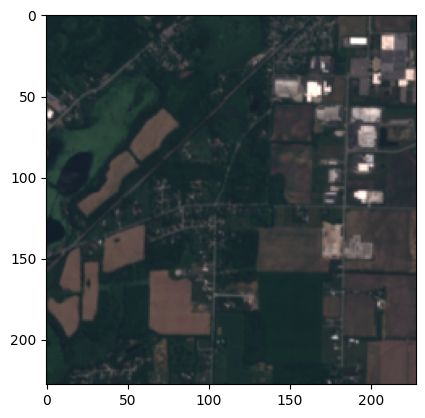

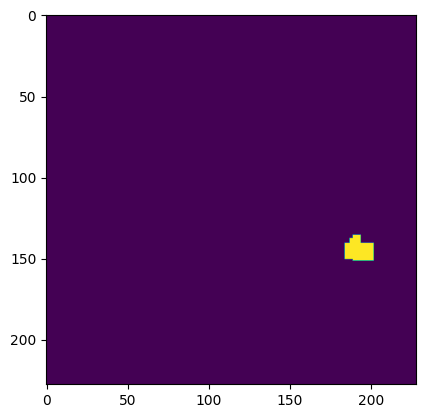

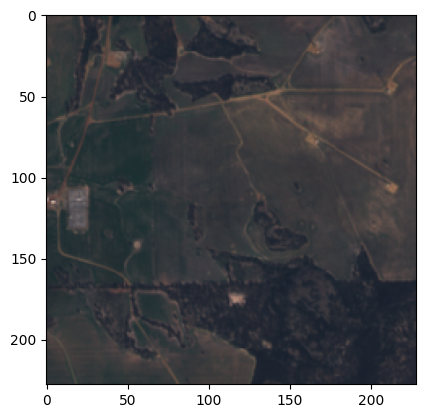

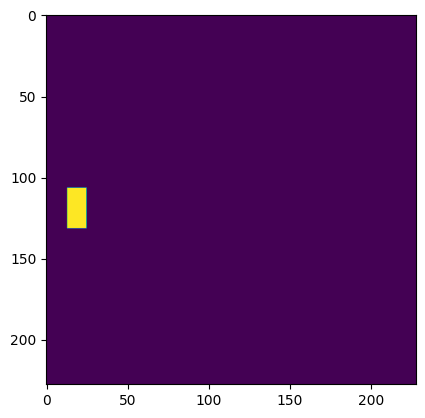

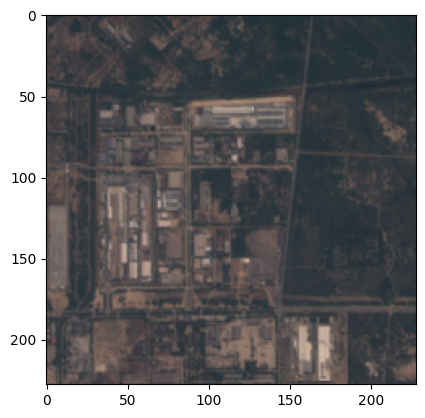

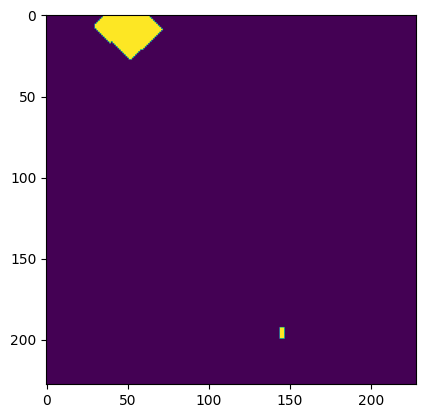

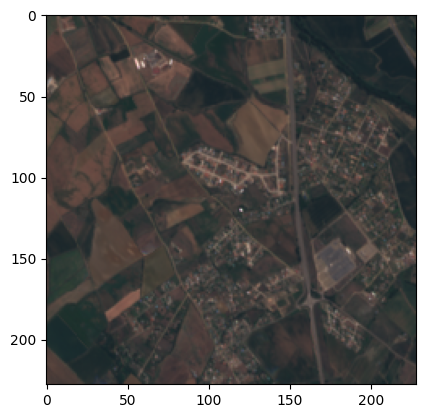

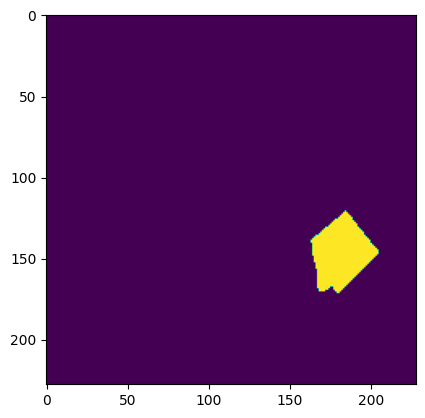

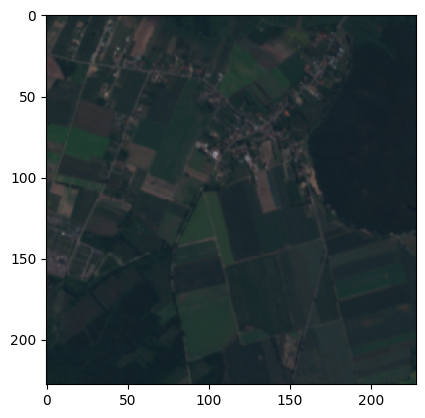

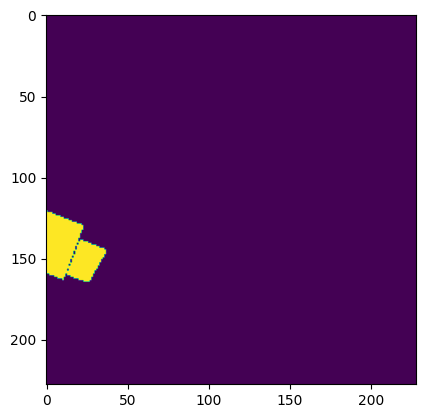

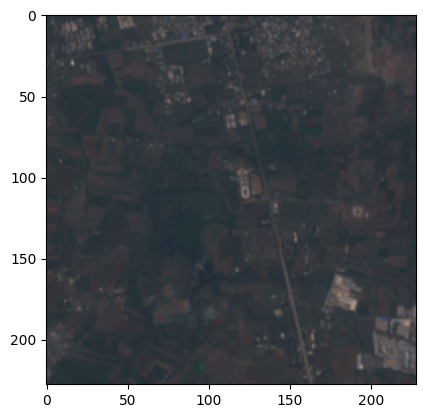

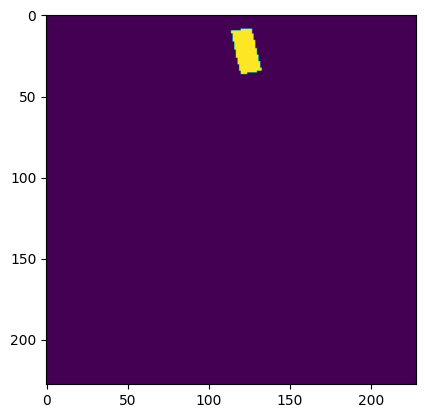

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


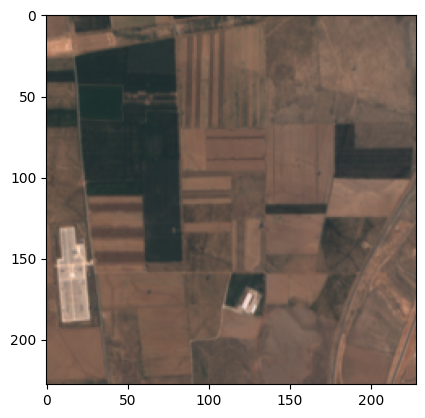

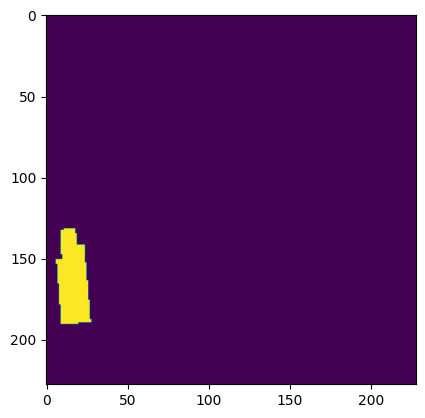

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


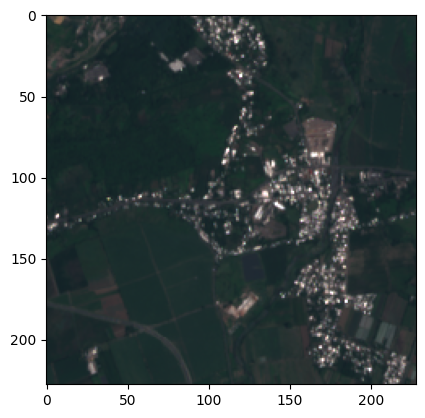

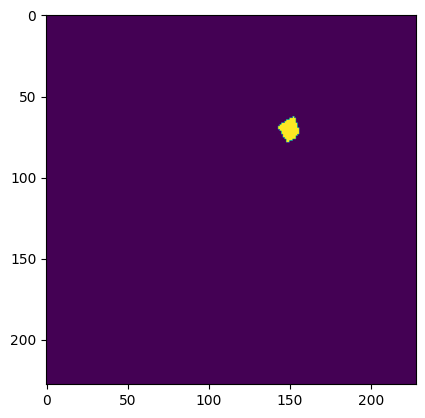

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


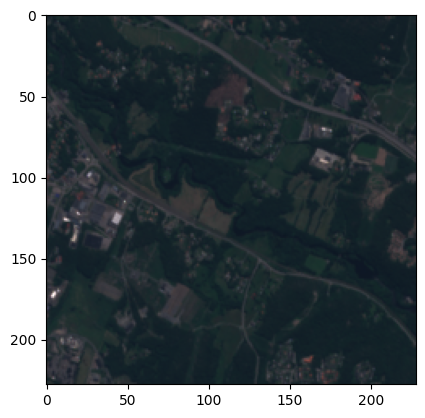

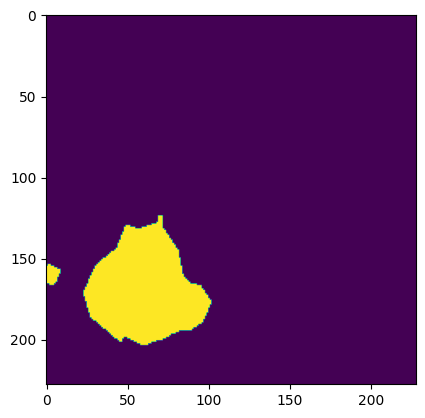

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


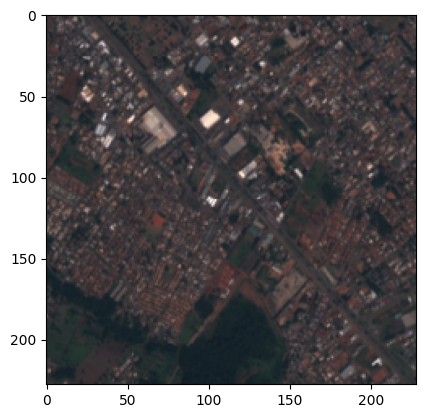

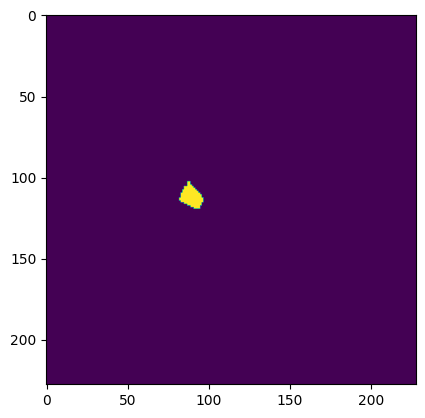

In [12]:
for i,(im,m) in enumerate(val_dataset):
    plt.imshow(im[[3,2,1],:,:].permute(1,2,0))
    plt.show()
    plt.imshow(m.permute(1,2,0))
    plt.show()
    if (i+1)%10==0:
        break

In [121]:
def compute_iou(im1, im2):
    intersection = torch.logical_and(im1, im2).sum().item()
    union = torch.logical_or(im1, im2).sum().item()
    iou = intersection / union if union > 0 else 0.0
    return iou

total_iou = 0
for i,(im,m) in enumerate(val_dataset):
    
    if i%100==0:
        print(i/len(val_dataset)*100,"% completed")
    
    im = transforms.Pad(14)(im)
    m = transforms.Pad(14)(m)
#     print(im.shape, m.shape)

    im_patches=im.unfold(1,64,64).unfold(2,64,64)
    m_patches=m.unfold(1,64,64).unfold(2,64,64)
    img_iou = 0
    for j in range(4):
        for k in range(4):
            output = torch.sigmoid(model(im_patches[:,j,k,:,:].to(device).float().unsqueeze(dim=0)))
            pred = (output>0.5).float().unsqueeze(dim=0)
            img_iou += compute_iou(pred, m_patches[:,j,k,:,:].to(device).float())
    total_iou+= img_iou/16
print("Total AVG IoU", total_iou/len(val_dataset))

0.0 % completed
1.8850141376060319 % completed
3.7700282752120637 % completed
5.655042412818096 % completed
7.5400565504241275 % completed
9.42507068803016 % completed
11.310084825636192 % completed
13.195098963242224 % completed
15.080113100848255 % completed
16.96512723845429 % completed
18.85014137606032 % completed
20.735155513666353 % completed
22.620169651272384 % completed
24.50518378887842 % completed
26.390197926484447 % completed
28.275212064090482 % completed
30.16022620169651 % completed
32.045240339302545 % completed
33.93025447690858 % completed
35.815268614514615 % completed
37.70028275212064 % completed
39.58529688972667 % completed
41.470311027332706 % completed
43.35532516493873 % completed
45.24033930254477 % completed
47.1253534401508 % completed
49.01036757775684 % completed
50.895381715362866 % completed
52.780395852968894 % completed
54.66540999057493 % completed
56.550424128180964 % completed
58.435438265787 % completed
60.32045240339302 % completed
62.205466540

In [77]:
from torchmetrics.classification import BinaryJaccardIndex
import time
metric = BinaryJaccardIndex(0.6)

In [90]:
def compute_iou(im1, im2):
    intersection = torch.logical_and(im1, im2).sum().item()
    union = torch.logical_or(im1, im2).sum().item()
    iou = intersection / union if union > 0 else 0.0
    return iou

patch_size= 64
image_size = 228
stride = 4
a = torch.ones((patch_size,patch_size))
b = torch.zeros((image_size ,image_size))
number_of_patches = (image_size - patch_size)//stride+1

for i in range(number_of_patches):
    for j in range(number_of_patches):
        b[i*stride:i*stride+patch_size, j*stride:j*stride+patch_size]=b[i*stride:i*stride+patch_size, j*stride:j*stride+patch_size]+a

count=0
preds=[]
# print(number_of_patches)
with torch.no_grad():
    total_iou = 0
    for i,(im,m) in enumerate(val_dataset):   
        start = time.time()

        
        c = torch.zeros((228,228))

        im_patches=im.unfold(1,patch_size,stride).unfold(2,patch_size,stride) #[13, num_patches,num_patches, 64, 64]
        m_patches=m.unfold(1,patch_size,stride).unfold(2,patch_size,stride)  #[1, num_patches, num_patches, 64, 64]

#         print(im_patches.shape, m_patches.shape)
        for j in range(number_of_patches):
            temp = im_patches[:,j,:,:,:].permute(1,0,2,3)
            output = torch.sigmoid(model(temp.to(device).float()))#(num_patches,1,64,64)
            
            for k in range(number_of_patches):
                c[j*stride:j*stride+64,k*stride:k*stride+64] += output[k].squeeze(dim=0).cpu()
        
        pred = c/b
        preds.append(pred)
#         img_iou = metric(pred.unsqueeze(dim=0), m)
        
#         if (m.int().sum().item() ==0) and  ((pred>0.6).int().sum()==0):
#             continue
#         else:
#             total_iou+= img_iou.item()
#             count+=1
            
        if (i+1)%500==0:
            print(i/len(val_dataset)*100,"% completed",)
#             print("Total AVG IoU", total_iou/count)
#     print("Total AVG IoU", total_iou/count)

9.4062205466541 % completed
18.83129123468426 % completed
28.25636192271442 % completed
37.68143261074458 % completed
47.10650329877474 % completed
56.53157398680491 % completed
65.95664467483506 % completed
75.38171536286522 % completed
84.80678605089538 % completed
94.23185673892554 % completed


In [2]:
import pickle
with open("preds_64x64_stride4","rb") as f:
    preds = pickle.load(f)

In [3]:
with open("val_masks","rb") as f:
    masks = pickle.load(f)

In [4]:
preds_tensor = torch.stack(preds)
preds_tensor.shape

torch.Size([5305, 228, 228])

In [6]:
from torchmetrics.classification import BinaryJaccardIndex
masks_tensor = torch.stack(masks)
metric = BinaryJaccardIndex(0.6)
total_iou = metric(preds_tensor[preds_tensor.sum(dim=(1,2))!=0], masks_tensor[preds_tensor.sum(dim=(1,2))!=0])
print(total_iou)

tensor(0.3074)


In [13]:
torch.logical_and(preds_tensor.sum(dim=(1,2))==0, masks_tensor.sum(dim=(1,2))==0).int().sum()

tensor(0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.39215686274509803


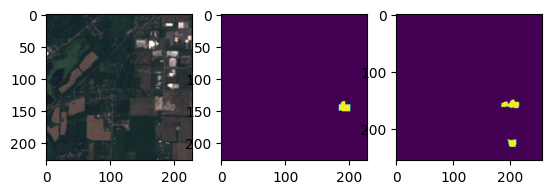

In [27]:
for i,(im,m) in enumerate(val_dataset):    
    fig, axs = plt.subplots(1,3)
    axs[0].imshow(im[[3,2,1],:,:].permute(1,2,0))
    axs[1].imshow(m.permute(1,2,0))
    axs[2].imshow((pred>0.5).int())
    print(compute_iou((pred>0.5).int(),transforms.Pad(14)(m).squeeze(0)))
    break

In [26]:
len(val_dataset)

5305

In [19]:
a = torch.ones((64,64))

In [20]:
b = torch.zeros((256,256))

In [25]:
for i in range(193):
    for j in range(193):
        b[i:i+64, j:j+64]=b[i:i+64, j:j+64]+a
        
print(b)

tensor([[1., 2., 3.,  ..., 3., 2., 1.],
        [2., 4., 6.,  ..., 6., 4., 2.],
        [3., 6., 9.,  ..., 9., 6., 3.],
        ...,
        [3., 6., 9.,  ..., 9., 6., 3.],
        [2., 4., 6.,  ..., 6., 4., 2.],
        [1., 2., 3.,  ..., 3., 2., 1.]])
